In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/isaac/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
train = pd.read_csv('Train.csv')

/Users/isaac/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# EDA

## Size of data.

In [3]:
train.shape

(401125, 53)

## What do my data look like?

In [4]:
from sklearn.pipeline import Pipeline

In [5]:
Pipeline?

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

Yuck, a lot of these columns have a ton of missing data. That's going to make them hard to deal with.

As a first approach let's just keep the model without missing vals.

In [7]:
column_counts = train.apply(lambda x: x.count(), axis=0)
keep_columns = column_counts[column_counts == column_counts.max()]
dense_train = train.ix[:,keep_columns.index]
dense_train.shape

(401125, 13)

Ok, so now for a first pass we can worry about just 13 columns.

In [8]:
dense_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 13 columns):
SalesID               401125 non-null int64
SalePrice             401125 non-null int64
MachineID             401125 non-null int64
ModelID               401125 non-null int64
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null object
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
dtypes: int64(6), object(7)
memory usage: 39.8+ MB


Ok, so let's build a model that focuses only on these characteristics.

First lets make sure we don't treat ids as Ints.

In [9]:
id_cols = ['SalesID', 'MachineID', 'ModelID']
dense_train[id_cols] = dense_train[id_cols].astype('str', inplace=True)
dense_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 13 columns):
SalesID               401125 non-null object
SalePrice             401125 non-null int64
MachineID             401125 non-null object
ModelID               401125 non-null object
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null object
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
dtypes: int64(3), object(10)
memory usage: 39.8+ MB


I want to do some EDA to see what these values are all about.

In [10]:
dense_train.describe()

,SalePrice,datasource,YearMade
count,401125.000000,401125.000000,401125.000000
mean,31099.712848,134.665810,1899.156901
std,23036.898502,8.962237,291.797469
min,4750.000000,121.000000,1000.000000
25%,14500.000000,132.000000,1985.000000
50%,24000.000000,132.000000,1995.000000
75%,40000.000000,136.000000,2000.000000
max,142000.000000,172.000000,2013.000000


Issues:
datasource is an ID
YearMade has some outliers.

## Address YearMade outliers.

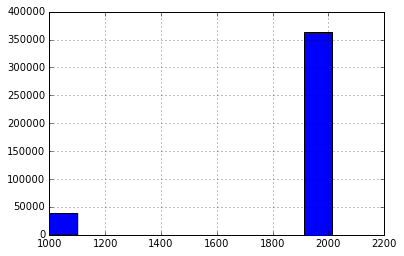

In [11]:
dense_train.YearMade.hist()

Oops, nothing to see there. Let's try:

In [12]:
dense_train.YearMade.value_counts()

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
1999    18767
2000    16742
1996    16691
1995    15528
1994    14199
2003    14161
2001    12938
2006    12215
2002    12031
1993    10971
1989    10693
1988    10395
1990    10250
1987    10105
1992     7587
1986     7508
1991     7361
1985     6475
1984     6111
1978     5623
1979     5557
1980     4677
1983     4557
2007     4523
1977     4379
        ...  
1967     1086
1966      943
1965      667
1964      414
1963      246
2009      168
1962      143
1919      127
1961       99
1960       97
1959       28
2010       25
1958       22
1956       20
2011       18
1920       17
1957       15
1950        8
1951        7
1953        6
1952        6
1955        5
1954        3
1948        3
2012        1
1949        1
1947        1
1942        1
1937        1
2013        1
Name: YearMade, dtype: int64

This is not great. The most frequently occurring value for YearMade is nonsense. These are probably actually missing values.

We have a few options here. We could just drop these values, if they're a small enough percentage of our overall data that might be ok.

In [13]:
(dense_train.YearMade.value_counts() / dense_train.YearMade.count()).head()

1000    0.095195
1998    0.052904
2005    0.051323
2004    0.049910
1997    0.047130
Name: YearMade, dtype: float64

Ok, it's about 10% of our data. That's not ideal so perhaps we don't want to drop it, but for some kinds of models we're going to want to do something. Let's try replacing those values with the mode, and creating an indicator column to note that we have done so, so we don't lose any information that might be associated with it being missing.

In [14]:
condition = dense_train.YearMade > 1900
mode = dense_train.YearMade[condition].mode()
dense_train.ix[~condition, 'YearMade'] = mode

In [15]:
dense_train.YearMade.value_counts()

1998.0    21221
2005.0    20587
2004.0    20020
1997.0    18905
1999.0    18767
2000.0    16742
1996.0    16691
1995.0    15528
1994.0    14199
2003.0    14161
2001.0    12938
2006.0    12215
2002.0    12031
1993.0    10971
1989.0    10693
1988.0    10395
1990.0    10250
1987.0    10105
1992.0     7587
1986.0     7508
1991.0     7361
1985.0     6475
1984.0     6111
1978.0     5623
1979.0     5557
1980.0     4677
1983.0     4557
2007.0     4523
1977.0     4379
1981.0     4144
          ...  
1967.0     1086
1966.0      943
1965.0      667
1964.0      414
1963.0      246
2009.0      168
1962.0      143
1919.0      127
1961.0       99
1960.0       97
1959.0       28
2010.0       25
1958.0       22
1956.0       20
2011.0       18
1920.0       17
1957.0       15
1950.0        8
1951.0        7
1953.0        6
1952.0        6
1955.0        5
1954.0        3
1948.0        3
1942.0        1
1937.0        1
2012.0        1
1947.0        1
1949.0        1
2013.0        1
Name: YearMade, dtype: i

# Dependent Variable

Let's see what we can learn about our dependent variable:

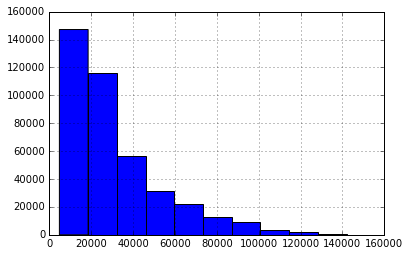

In [16]:
dense_train.SalePrice.hist()

This picture is a little bit surprising, it looks more like an exponential distribution than anything else. We might expect a more normal distribution for any given vehicle, but evidently our data set is so full of different types of vehicles that we get this shape. There are also apparently a lot of low-priced vehicles.

Since our RMSLE error metric penalizes underpredictions, we'll want to make sure that we do well on the right tail of this distribution and don't just focus on the common vehicles.

# Let's try to build our first model.

We've taken care of some outlier values in the model year, but let's step back and talk about why. 

Since we're talking about used equipment here, there are a few things that I believe matter to the price. If I were to rank them I would list them from most to least important as:

1. What is a reasonable price for this vehicle? We don't have any columns in our data that tell us this, but the idea is that there are probably very different prices paid for more or less expensive pieces of equipment. If I knew what original cost of the vehicles was, this, along with the age would probably help me. As it is, I can probably get a estimate of the price by taking an average of similar vehicles sold recently. What the best notion of similar should be is unclear... so we may want to experiement in this regard.
2. The age of the vehicle. Surely older vehicles cost less than newer ones right? We have the model year, but we'll need to compute the age on the date of sale for best results.
3. How heavily used the vehicle is. Surely more heavily used vehicles are less expensive. Unfortunately there are a lot of missing values in the machinehoursusage. Let's investigate.

As we discover things that are relevant we will include them in our more rigorous model file in heavy_equipment_model.py. That's where will ultimately do cross validation and use pipelining to assure that our model works on unseen data.

In [17]:
mhcm = train.MachineHoursCurrentMeter
print (mhcm == 0).sum(), ' zero values'
print mhcm.isnull().sum(), ' missing values'

73126  zero values
258360  missing values


So in addition to the missing values, there are a lot of values set at zero, which probably represent missing vals too.

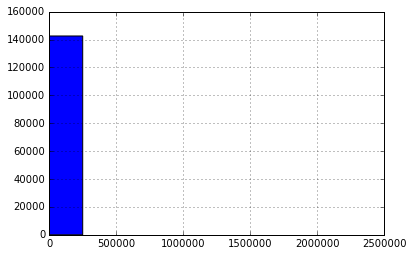

In [18]:
mhcm.hist()

This kind of worthless histogram can happen when there are outliers. We know there are also a lot of zeros, so let's clean those out and try to get a sense of the shape in a reasonably dense range.

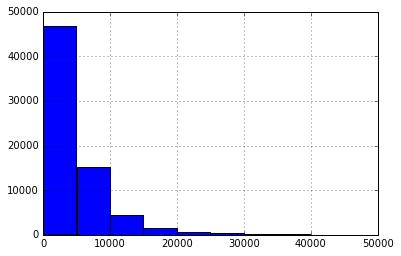

In [19]:
mhcm.ix[(mhcm>0) & (mhcm<50000)].hist()

Ok this sort of worked, but it looks like we have a really long tail of outliers, which is going to be cause for concern. How can we effectively learn the behavior of our model when the data takes on extreme values but only infrequently?

In [20]:
(mhcm > 100000).sum()

426

A boxplot lets us see the issue more clearly:

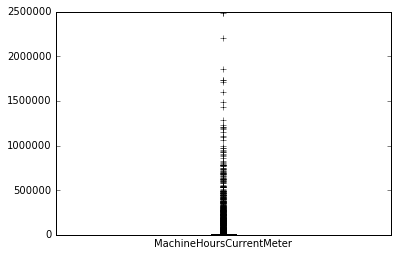

In [21]:
mhcm.plot(kind='box')

It's not obvious these things are outliers in the sense that they're just crazy data, it seems possible there are some really heavily used machines in the auction occassionally. We could consider ignoring these things, there are only a few hundred, but we'll certainly want to keep these in mind as we proceed.


For now, let's not focus on the hours, this data is looking very difficult, so let's try to build an initial model that doesn't include it.

For our age, we can calculate this by taking the difference between the saledate and the year made.


In [22]:
dense_train['saledate_converted'] = pd.to_datetime(dense_train.saledate)


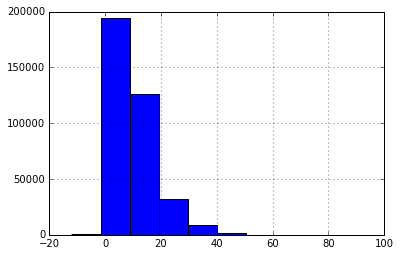

In [23]:
dense_train['equipment_age'] = dense_train.saledate_converted.dt.year - dense_train.YearMade
dense_train.equipment_age.hist()

Ok, this graph looks pretty reasonable, but maybe a few outliers on both sides:

In [24]:
dense_train.equipment_age.describe()

count    362940.000000
mean         10.220477
std           7.569398
min         -12.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          92.000000
Name: equipment_age, dtype: float64

In [25]:
age = dense_train.equipment_age
(age<0).sum(), (age > 50).sum()

(13, 196)

Let's see what our variables look like here.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115d38590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115b58c90>]], dtype=object)

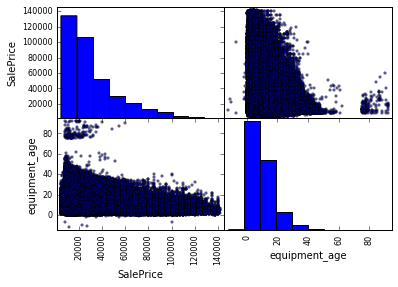

In [26]:
pd.scatter_matrix(dense_train[['SalePrice', 'equipment_age']])

Based on the graph above, it looks like there's a bit of a collection of outliers at around 60 years old. We might be able to filter those out, or want to build another model on them.

Ok, now we return to 1. above. We want to an average price of similar vehicle. There are many ways to think about similarity including:

1. Geography (look at nearby sales)
2. Time (look at recent sales)
3. Vehicle (look at sales that are most similar in terms of vehicle)
4. Similar usage
5. Similar age
etc.

Ultimately choosing what similarity metric we should use is quite difficult, so for now let's try to do something easy and reasonable. What about the five most recent sales of the same modelid? 

If there aren't 5 such sales of course we'll have to do something else, but let's see how big that problem is before we solve it.

In [27]:
#Set multi-level index and sort by modelid and saledate, so we can use window functions.
#dense_train = dense_train.reset_index()
dense_train.sort_values(by='saledate_converted', inplace=True)

In [209]:
m = dense_train.groupby('ModelID')['SalePrice'].apply(lambda x: x.rolling(5).agg([np.mean]))

In [251]:
z = pd.concat([m, dense_train[['saledate_converted', 'ModelID', 'SalesID']]], axis=1)
z['saledate_converted'] = z.saledate_converted + timedelta(1)
#Some days will have more than 1 transaction for a particular model, take the last mean (which has most info)
z = z.groupby(['ModelID', 'saledate_converted']).apply(lambda x: x.tail(1))

If we're going to use this as an input, we don't want to use an average value that could include the price of the vehicle we're trying to predict. So we'll want to shift the dates so that we can merge on the average we would have calculated the day before observing the transaction.

This is a little tricky, we need to find the closest date that is less than the transaction date and for which we have an average.

We're going to merge based on modelid and date then use fill forward to get the nearest value for any transaction (there will still be missing values).

In [252]:
near_price = pd.merge(z.drop('SalesID', axis=1), dense_train, how='outer', 
                      on=['ModelID', 'saledate_converted'])
near_price = near_price.set_index(['ModelID', 'saledate_converted']).sort_index()
g = near_price['mean'].groupby(level=0)
near_price['filled_mean_price'] = g.transform(lambda x: x.fillna(method='ffill'))

/Users/isaac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  app.launch_new_instance()


Ok, in the dataset above, the observations missing a SalesID come only from our averages table and can be dropped.

In [254]:
near_price = near_price[near_price.SalesID.notnull()]
near_price.shape

(401125, 15)

Ok, we're getting there. Some of our transactions in this data set will not have a 'filled mean price' because there were no previously observed transactions. Fortunately there aren't too many such observations (though this is all within the training data, so it's likely that in reality we might encounter more such cases). It's possible we could build a separate model for predicing these transactions.

In [257]:
near_price.filled_mean_price.describe()

count    379643.000000
mean      31099.690989
std       21603.158082
min        4950.000000
25%       15000.000000
50%       24300.000000
75%       40600.000000
max      140000.000000
Name: filled_mean_price, dtype: float64

What was the point of all this recent mean nonsense? Well, it was my belief that the recent mean would have predictive power of the saleprice. Was it worth it? The histogram of mean price - sale price should be instructive:

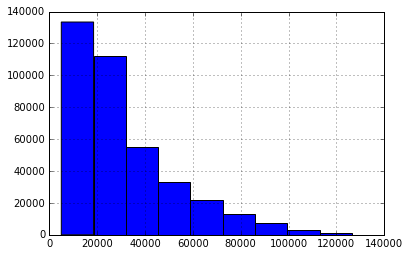

In [281]:
(near_price.filled_mean_price).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1299e3d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129f2a550>]], dtype=object)

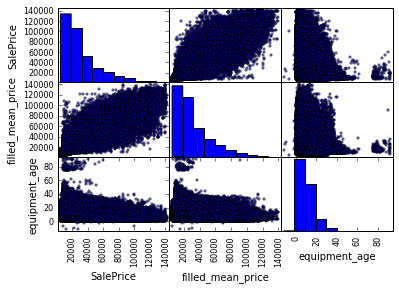

In [273]:
pd.scatter_matrix(near_price[['SalePrice', 'filled_mean_price', 'equipment_age']])

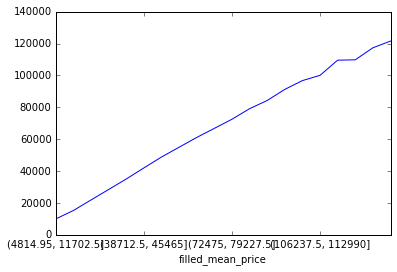

In [276]:
def percentile_plots(x, y):
    cuts = pd.cut(x, 20)
    y.groupby(cuts).mean().plot()
percentile_plots(near_price.filled_mean_price, near_price.SalePrice)

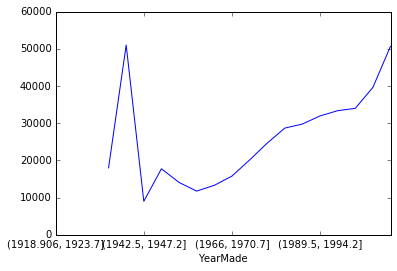

In [280]:
percentile_plots(near_price.YearMade, near_price.SalePrice)

So the mean price and sale price are definitely correlated here, it should certainly be helpful.

Ok, so we are now ready to build our first model. 

I've been building in this functionality into heavy_equipment_model.py, which you should take a look at now. This uses the same ideas as above, but implements it using the Pipeline class, which is (extremely, very) helpful for preventing target leakage.

One thing we'll want to do now is set up a cross validation set. Our heldout set is future transactions, so we're going to want to choose a cv set using time as well. Let's see how we might do that.

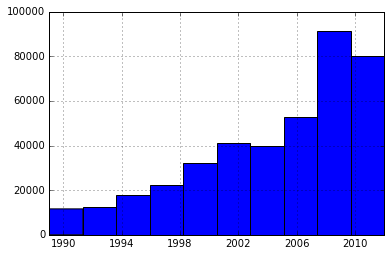

In [265]:
dense_train.saledate_converted.hist()

Ok, looks like we have more transactions recently, and we don't want to make our lives too hard by choosing a validation set that includes all of our most useful data.

In [269]:
dense_train.saledate_converted.quantile([.7, .8, .9, 1])

0.7   2008-10-22
0.8   2009-09-12
0.9   2010-10-30
1.0   2011-12-30
Name: saledate_converted, dtype: datetime64[ns]

Based on this, I would say that we probably don't want to use the usual 70/30 split, because it looks like maybe there was a change in our data collection around 2009. We've got a little less than 10% of our data represented by 2011, which isn't a huge cv data set, but I think makes sense under the circumstances. If anything, it's on the small, side so it might be reasonable to consider other datasets.

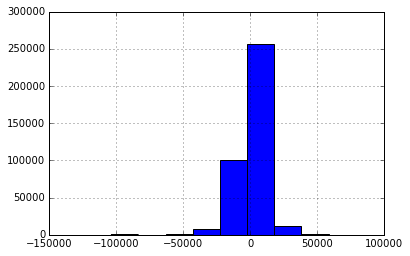

In [271]:
(near_price.filled_mean_price-near_price.SalePrice).hist()

Once we've fit a model, we're ready to iterate. A good way to prioritize future efforts would be to look at the residuals of our model and how the correlate with some of our predictors (either ones already included in the model or not). For example, if I thought state might be important, I could see if there are any significant differences in the residuals by state (using a boxplot visually, or a statistical test). If so, then I could decide to include that. We've taken the easy way out re: a lot of our variables with missing values, but we might be able to do some transformations to make them work out better.

## Laundry list of future work.

If we run the model in `heavy_equipment_model.py`, we get a RMSLE on our own cross validation data set of $~.34$. This chooses the optimal number of similar transactions via cross validation (5 is considered the best). Some other things to do:

1. Work on machine hours.
2. Check the 4 and 6 values for similarity.
3. Cross validate different imputation techniques for age outliers (mean, median etc.)
5. See if there are any spatial relationships (space for example).
6. Try to fit a more sophisticated model.
7. Maybe fit a separate model for very old models, the scatter plot of equipment age shows two separate clusters.
8. Include other features which we discarded for being too sparse.
9. Extract information from unstructured text.